<a href="https://colab.research.google.com/github/kamyllalima/kamyllalima/blob/main/C%C3%B3pia_de_indicadores_monitor_rosa_cnes_pf_05_08_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação
Este notebook foi desenvolvido como parte do projeto Monitor Rosa, um conjunto de ferramentas, softwares e outros artefatos cujo principal objetivo é melhorar o cenário de diagnósticos de câncer de mama no Brasil, idealmente melhorando diminuindo a proporção de diagnósticos tardios/diagnósticos precoces.

Os arquivos utilizados neste notebook foram coletados através dos scripts presentes [neste repositório](https://github.com/heber-augusto/devops-pysus-get-files). Os arquivos foram armazenados em um bucket do Google Storage no formato parquet compactados (gzip).

O principal objetivo deste notebook é consolidar os arquivos coletados do ftp do SUS em bases/arquivos que facilitem análises e utilização dos dados.

Os arquivos criados por este notebook possuem apenas os dados de SP, estão salvos em uma pasta chamada "consolidado" (no mesmo bucket do google onde estão salvos os arquivos coletados do FTP do SUS) e são organizados em:

 - pacientes.parquet.gzip: informações consolidadas de cada paciente (detalhes [neste comando](#scrollTo=N9Kzt8iI24Iw));
 - cancer.parquet.gzip: informações consolidadas dos dois tipos de procedimentos - quimioterapia e radioterapia (detalhes [neste comando](#scrollTo=iMkYq9UGIhP6));
 - cancer_aq.parquet.gzip: registros de quimioterapia consolidados em um único arquivo (criado a partir [deste comando](#scrollTo=bCCfeKAdMM0y));
 - cancer_ar.parquet.gzip: registros de radioterapia consolidados em um único arquivo (criado a partir [deste comando](#scrollTo=bCCfeKAdMM0y));
 - procedimentos_e_pacientes.parquet.gzip: Procedimentos com dados consolidados de pacientes (criado a partir [deste comando](#scrollTo=6zSk7STZdbVI));
 - dados_estad_municipio_mensal.parquet.gzip: dados consolidados por mês/municipio/estadiamento (criado a partir [deste comando](#scrollTo=N65hubVP_--P));
 - dados_estad_mensal.parquet.gzip: dados consolidados por mês/estadiamento (criado a partir [deste comando](#scrollTo=zta5pk3Oj4Vj)).




# Instalação de bibliotecas e pacotes para leitura de arquivos

In [1]:
import glob
import os
from google.colab import auth

## Bibliotecas utilizadas na análise exploratória

In [2]:
import pandas as pd
import numpy as np

## Configurações iniciais para conectar com bucket no Google Storage
 - Autenticação do Google Colab
 - Definição do nome do projeto

 Para a execução dos comandos desta seção, o arquio gcp-leitura.json deve ser inserido na raiz do colab.

In [3]:
# auth.authenticate_user()

# id do projeto
project_id = 'teak-ellipse-317015'
# id do bucket dentro do projeto
bucket_id = 'observatorio-oncologia'

# nome da pasta local para mapear
local_folder_name = 'colab'

# nome da pasta do projeto
project_folder_name = 'monitor'

# estado contendo consolidação dos dados
state = 'SP'


## Definições globais

In [4]:

DESTINATION_FOLDER = os.path.join(
    r'/content/',
    local_folder_name,
    project_folder_name,
    state)
DESTINATION_FOLDER = f'{DESTINATION_FOLDER}/consolidado/'
DESTINATION_FOLDER

'/content/colab/monitor/SP/consolidado/'

## Instalação para garantir montagem da pasta no bucket
Instalação do gcsfuse para mapear pasta do bucket no google colab

In [5]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb
!sudo dpkg --install gcsfuse_0.41.12_amd64.deb
# !apt -qq install gcsfuse


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12.7M  100 12.7M    0     0  22.0M      0 --:--:-- --:--:-- --:--:-- 22.0M
Selecting previously unselected package gcsfuse.
(Reading database ... 120500 files and directories currently installed.)
Preparing to unpack gcsfuse_0.41.12_amd64.deb ...
Unpacking gcsfuse (0.41.12) ...
Setting up gcsfuse (0.41.12) ...


# Versão mais recente do gcsfuse (0.42.0), não está funcionando no colab

In [6]:
# !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
# !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
# !apt -qq update
# !apt -qq install gcsfuse

## Nome/caminho do arquivo json contendo credenciais de acesso ao storage do Google

In [7]:
service_account_json = '/content/gcp-leitura.json'

## Montagem do bucket em uma pasta local do google colab

In [8]:
!mkdir {local_folder_name}
!gcsfuse --key-file {service_account_json} --implicit-dirs {bucket_id} {local_folder_name}

2023/08/05 10:23:47.814089 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/colab
2023/08/05 10:23:47.837991 Opening GCS connection...
2023/08/05 10:23:48.791741 Mounting file system "observatorio-oncologia"...
2023/08/05 10:23:48.792627 File system has been successfully mounted.


## Função para facilitar coleta de arquivo

In [9]:
def get_files(state, year, month, file_type, file_group):
    initial_path = os.path.join(r'/content/',local_folder_name,project_folder_name)
    internal_folder = f"""{state}/{year}/{month}/{file_type}/{file_group}"""
    # print(f"{initial_path}/{internal_folder}/*.parquet.gzip")
    return glob.glob(f"{initial_path}/{internal_folder}/*.parquet.gzip")

In [10]:
# CBO
#225121 Médico oncologista clínico
#225122 Médico cancerologista pediátric

arquivos = get_files('SP', 2021, 11, 'CNES', 'PF')
pf_test = pd.read_parquet(arquivos[0])
pf_test.info()
pf_test[(pf_test.CBO == '225121') | (pf_test.CBO == '225122')]





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203622 entries, 0 to 1203621
Data columns (total 40 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   CNES      1203622 non-null  object
 1   CODUFMUN  1203622 non-null  object
 2   REGSAUDE  1203622 non-null  object
 3   MICR_REG  1203622 non-null  object
 4   DISTRSAN  1203622 non-null  object
 5   DISTRADM  1203622 non-null  object
 6   TPGESTAO  1203622 non-null  object
 7   PF_PJ     1203622 non-null  object
 8   CPF_CNPJ  1203622 non-null  object
 9   NIV_DEP   1203622 non-null  object
 10  CNPJ_MAN  1203622 non-null  object
 11  ESFERA_A  1203622 non-null  object
 12  ATIVIDAD  1203622 non-null  object
 13  RETENCAO  1203622 non-null  object
 14  NATUREZA  1203622 non-null  object
 15  CLIENTEL  1203622 non-null  object
 16  TP_UNID   1203622 non-null  object
 17  TURNO_AT  1203622 non-null  object
 18  NIV_HIER  1203622 non-null  object
 19  TERCEIRO  1203622 non-null  object
 20  CP

,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,...,VINCUL_A,VINCUL_N,PROF_SUS,PROFNSUS,HORAOUTR,HORAHOSP,HORA_AMB,COMPETEN,UFMUNRES,NAT_JUR
5439,2048205,350160,0212,,,,M,3,00000000000000,3,...,0,0,1,0,0,0,15,202111,000000,1244
6459,2058790,350160,0207,,,,M,3,00000000000000,3,...,0,0,1,0,0,7,7,202111,000000,1155
6892,2082179,350160,0207,,,,M,3,43252758000120,1,...,1,0,1,0,0,1,1,202111,000000,3999
9386,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,14,202111,000000,2062
9389,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,8,202111,000000,2062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199415,0920770,355710,,,,,M,1,22021082890,1,...,1,0,1,0,0,0,8,202111,000000,4000
1201338,2081377,355710,0215,,,,E,3,72957814000120,1,...,1,0,0,1,0,2,2,202111,000000,3999
1201652,2084309,355710,0215,,,,M,3,53807475000584,1,...,1,0,0,1,0,1,0,202111,000000,2143
1203021,7968957,355710,0215,,,,M,1,31293244880,1,...,1,0,0,1,0,0,10,202111,000000,4000


In [11]:
colunas = ['CNES', 'CODUFMUN', 'REGSAUDE', 'MICR_REG', 'CBO' ]
pf_test[colunas]

,CNES,CODUFMUN,REGSAUDE,MICR_REG,CBO
0,0047406,350010,0209,,251510
1,0081655,350010,R209,,223605
2,0109789,350010,0209,,251510
3,0109827,350010,0209,,251510
4,0183555,350010,0209,,223208
...,...,...,...,...,...
1203617,7758561,355730,,,322205
1203618,7758561,355730,,,251505
1203619,7758561,355730,,,251510
1203620,7758561,355730,,,251605


In [12]:
pf_test[colunas].describe()

,CNES,CODUFMUN,REGSAUDE,MICR_REG,CBO
count,1203622,1203622,1203622,1203622,1203622
unique,79661,644,262,171,982
top,2078015,355030,,,322205
freq,24967,376976,283390,1088879,145859


In [13]:
count = pf_test['CBO'].value_counts()['225121']
print ("Quantidade de Médico oncologista clínico:" , count)
count = pf_test['CBO'].value_counts()['225122']
print ("Quantidade de Médico cancerologista pediátrico:", count)
#225121 Médico oncologista clínico = 3546
#225122 Médico cancerologista pediátrico = 198

Quantidade de Médico oncologista clínico: 3546
Quantidade de Médico cancerologista pediátrico: 198


In [14]:
pf_test = pd.read_parquet(arquivos[0])
result = pf_test[pf_test['CBO'] == '225121'].groupby('CODUFMUN')['CBO'].count()
print(result)
#Contagem de 225121 Médico oncologista clínico por município.

CODUFMUN
350160     7
350190     1
350210     7
350280    18
350320    23
          ..
355410    47
355500     3
355620    13
355700     5
355710     5
Name: CBO, Length: 96, dtype: int64


CODUFMUN
350280     2
350550    13
350600     3
350750     3
350760     1
350950    11
351620     2
351880     1
352440     1
352530     3
352590     1
352900     8
353440     2
354120     1
354140    18
354340    13
354780    17
354850     3
354870     1
354980     4
354990     9
355030    75
355220     5
355410     1
Name: CBO, dtype: int64


<Axes: xlabel='CODUFMUN'>

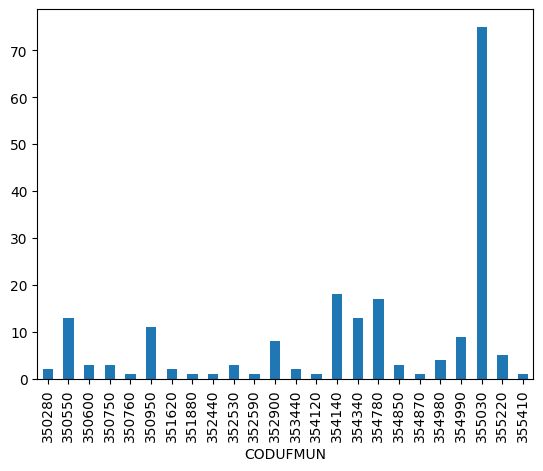

In [15]:
pf_test = pd.read_parquet(arquivos[0])
result = pf_test[pf_test['CBO'] == '225122'].groupby('CODUFMUN')['CBO'].count()
print(result)
result.plot(kind='bar')
#Contagem de 225122 Médico cancerologista pediátrico por município.

# CNES PF: Leitura, filtro e transformação inicial dos arquivos

## Informações sobre filtros pertinentes ao contexto de câncer de mama:

Descrição das colunas do arquivo PF:

0   CNES      Número nacional do estabelecimento de saúde;

 1   CODUFMUN  Código do município do estabelecimento UF+ MUNIC (sem dígito)

 2   REGSAUDE  Código da região de saúde

 3   MICR_REG  Código da micro-região de saúde

 4   DISTRSAN  Código do distrito sanitário

 5   DISTRADM  Código do distrito administrativo

 6   TPGESTAO  Gestão de saúde

 7   PF_PJ     Indicador de pessoa: 1-Física 3-Jurídica

 8   CPF_CNPJ  CPF do Estabelecimento, caso pessoa física ou CNPJ, caso pessoa jurídica

 9   NIV_DEP   Grau de dependência, onde: 1-Individual 3-Mantida

 10  CNPJ_MAN  CNPJ da mantenedora do estabelecimento

 11  ESFERA_A  Código da esfera administrativa

 12  ATIVIDAD  Código da atividade de ensino

 13  RETENCAO  Código de retenção de tributos

 14  NATUREZA  Código da natureza da organização

 15  CLIENTEL  Código de fluxo da clientela

 16  TP_UNID   Tipo de unidade (estabelecimento)

 17  TURNO_AT  Código de turno de atendimento

 18  NIV_HIER  Código do nível de hierarquia

 19  TERCEIRO  O estabelecimento é terceiro: 1-Sim 0-Não 2-não

 20  CPF_PROF  CPF do Profissional ou caso “99999999999” caso não seja
 preenchido.

 21  CPFUNICO  Contador de CPF ÚNICO do Profissional

 22  CBO       Código da especialidade do profissional

 23  CBOUNICO  Registro único do Código da especialidade do profissional

(este registro acontece somente uma vez por chave única CPF + CBO)

 24  NOMEPROF  Nome do profissional

 25  CNS_PROF  CNS do profissional ou “999999999999999” caso não seja preenchido.

 26  CONSELHO  Código do conselho de classe

 27  REGISTRO  Número do registro no conselho de classe

 28  VINCULAC  Vínculo empregatício com o estabelecimento:

 29  VINCUL_C  Vínculo empregatício com o estabelecimento: Contratado SUS

 30  VINCUL_A  Vínculo empregatício com o estabelecimento: Autônomo SUS

 31  VINCUL_N  Vínculo empregatício com o estabelecimento: Vínculo não identificado

 32  PROF_SUS  Caracterização do PROFISSIONAL que realiza ATENDIMENTO SUS

 33  PROFNSUS  Caracterização do PROFISSIONAL que realiza ATENDIMENTO NÃO SUS

 34  HORAOUTR  Carga horária não ambulatorial, nem hospitalar

 35  HORAHOSP  Carga horária HOSPITALAR

 36  HORA_AMB  Carga horária AMBULATORIAL

 37  COMPETEN  Ano e Mês de competência da informação (AAAAMM)

 38  UFMUNRES  Código da UF + município de residência do profissional (sem dígito)

 39  NAT_JUR   Natureza Jurídica



## Funções de filtro para arquivo CNES PA, AR, EQ e PF

*   Item de lista
*   Item de lista



In [16]:
def filter_pa_content(df):
    """

    """
    return df[df.PA_CIDPRI.isin(cid_filter) & \
              df.PA_PROC_ID.isin(proc_id_filter)]

def filter_ar_content(df):
    """

    """
    return df[df.AP_CIDPRI.isin(cid_filter)]

filter_aq_content = filter_ar_content


def filter_eq_content(df):
    """

    """
    return df[(df.TIPEQUIP == '1') & ((df.CODEQUIP == '02') | (df.CODEQUIP == '03'))]


def filter_pf_content(df):
    """

    """
    return df[(df.CBO == '225121') | (df.CBO == '225122')]

def no_filter_content(df):
    """

    """
    return df


def contagem_total_content(df):
    """

    """
    return df




## Função para unir diversos arquivos em um único datraframe

In [17]:
def create_cancer_dataframe(file_paths, filter_function=filter_pf_content):
    """

    """
    filtered_contents = [
      filter_function(pd.read_parquet(file_path))
      for file_path in file_paths
      ]

    return pd.concat(
        filtered_contents,
        ignore_index=True)



## Função para retornar lista de arquivos (caminho completo)

In [18]:
def get_file_paths(states, years, months, file_type, file_group):
    """

    """
    file_paths = []
    for state in states:
        for year in years:
            for month in months:
                file_paths.extend(
                    get_files(
                        state,
                        year,
                        month,
                        file_type,
                        file_group)
                )
    return file_paths

## CNES PF: Leitura e união de dados para o período desejado




### Estado, anos e meses a serem lidos e processados

In [19]:
states = [state,]
start_year = 2021
end_year = 2022
years  = [f'{year + start_year:02d}' for year in range(end_year - start_year + 1)]
months = [f'{month + 1:02d}' for month in range(12)]
file_type = 'CNES'

### Monta lista de arquivos a serem lidos

In [20]:
file_paths_by_type = {}

# Arquivos de produção ambulatorial
file_paths_by_type['PF'] = get_file_paths(
    states,
    years,
    months,
    file_type,
    'PF'
)
file_paths_by_type

{'PF': ['/content/colab/monitor/SP/2021/01/CNES/PF/PFSP2101.parquet.gzip',
  '/content/colab/monitor/SP/2021/02/CNES/PF/PFSP2102.parquet.gzip',
  '/content/colab/monitor/SP/2021/03/CNES/PF/PFSP2103.parquet.gzip',
  '/content/colab/monitor/SP/2021/04/CNES/PF/PFSP2104.parquet.gzip',
  '/content/colab/monitor/SP/2021/05/CNES/PF/PFSP2105.parquet.gzip',
  '/content/colab/monitor/SP/2021/06/CNES/PF/PFSP2106.parquet.gzip',
  '/content/colab/monitor/SP/2021/07/CNES/PF/PFSP2107.parquet.gzip',
  '/content/colab/monitor/SP/2021/08/CNES/PF/PFSP2108.parquet.gzip',
  '/content/colab/monitor/SP/2021/09/CNES/PF/PFSP2109.parquet.gzip',
  '/content/colab/monitor/SP/2021/10/CNES/PF/PFSP2110.parquet.gzip',
  '/content/colab/monitor/SP/2021/11/CNES/PF/PFSP2111.parquet.gzip',
  '/content/colab/monitor/SP/2021/12/CNES/PF/PFSP2112.parquet.gzip',
  '/content/colab/monitor/SP/2022/01/CNES/PF/PFSP2201.parquet.gzip',
  '/content/colab/monitor/SP/2022/02/CNES/PF/PFSP2202.parquet.gzip',
  '/content/colab/monitor/SP

In [21]:
ibge = pd.read_csv('/content/colab/monitor/ibge_data/ibge_cidades.csv', sep=';')

In [22]:
print(f"""Identificados {len(file_paths_by_type['PF'])} arquivos de profissionais""")


Identificados 24 arquivos de profissionais


# Montagem do dataset cancer PF

Este dataset (cancer_dataframe_pf) consolidam os registros de todos os anos/meses, coletados do FTP do SUS, em um único dataframe, aplicando um filtro de tipo e código de profissionais.

O código de profissionais deve ser um dos dois a seguir:
#CBO
#225121 Médico oncologista clínico
#225122 Médico cancerologista pediátrico

Esses dois filtros são definidos na função **filter_pf_content**


## Cria um único dataframe a partir dos conteúdos filtrados
**ESTE PASSO PODE SER PULADO CASO OS ARQUIVOS JÁ ESTEJAM CRIADOS. NESTE CASO, SEGUIR PARA LEITURA ([NESTE COMANDO](#scrollTo=01d35Inz8hju))**

In [23]:
cancer_dataframe_pf = create_cancer_dataframe(
    file_paths_by_type['PF'],
    filter_function=filter_pf_content)

cancer_dataframe_pf
# CBO
#225121 Médico oncologista clínico
#225122 Médico cancerologista pediátric
# Qual a quantidade de profissionais por cidade?
# Qual a quantidade de profissionais por estado?
# qual é a quantidade de profissionais dos CBO´s relacionados a cancer?


,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,...,VINCUL_A,VINCUL_N,PROF_SUS,PROFNSUS,HORAOUTR,HORAHOSP,HORA_AMB,COMPETEN,UFMUNRES,NAT_JUR
0,2048205,350160,0212,,,,M,3,00000000000000,3,...,0,0,1,0,0,0,7,202101,000000,1244
1,2058790,350160,0207,,,,M,3,00000000000000,3,...,0,0,1,0,0,12,0,202101,000000,1155
2,2082179,350160,0207,,,,M,3,43252758000120,1,...,1,0,1,0,0,1,1,202101,000000,3999
3,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,14,202101,000000,2062
4,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,8,202101,000000,2062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90165,2081377,355710,0215,,,,E,3,72957814000120,1,...,1,0,1,0,0,2,2,202212,000000,3999
90166,2081377,355710,0215,,,,E,3,72957814000120,1,...,1,0,0,1,0,2,2,202212,000000,3999
90167,2084309,355710,0215,,,,M,3,53807475000584,1,...,1,0,0,1,0,1,0,202212,000000,2143
90168,7968957,355710,0215,,,,M,1,31293244880,1,...,1,0,0,1,0,0,10,202212,000000,4000


## Salva arquivos para acelerar próximas execuções do notebook

In [24]:
cancer_dataframe_pf.to_parquet(
    'cancer_pf.parquet.gzip',
    compression='gzip')

[texto do link](https://)## Dataframe de PF

In [25]:
cancer_dataframe_pf

,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,...,VINCUL_A,VINCUL_N,PROF_SUS,PROFNSUS,HORAOUTR,HORAHOSP,HORA_AMB,COMPETEN,UFMUNRES,NAT_JUR
0,2048205,350160,0212,,,,M,3,00000000000000,3,...,0,0,1,0,0,0,7,202101,000000,1244
1,2058790,350160,0207,,,,M,3,00000000000000,3,...,0,0,1,0,0,12,0,202101,000000,1155
2,2082179,350160,0207,,,,M,3,43252758000120,1,...,1,0,1,0,0,1,1,202101,000000,3999
3,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,14,202101,000000,2062
4,5284007,350160,0207,,,,M,3,05577195000150,1,...,1,0,0,1,0,0,8,202101,000000,2062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90165,2081377,355710,0215,,,,E,3,72957814000120,1,...,1,0,1,0,0,2,2,202212,000000,3999
90166,2081377,355710,0215,,,,E,3,72957814000120,1,...,1,0,0,1,0,2,2,202212,000000,3999
90167,2084309,355710,0215,,,,M,3,53807475000584,1,...,1,0,0,1,0,1,0,202212,000000,2143
90168,7968957,355710,0215,,,,M,1,31293244880,1,...,1,0,0,1,0,0,10,202212,000000,4000


In [26]:
cancer_dataframe_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90170 entries, 0 to 90169
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CNES      90170 non-null  object
 1   CODUFMUN  90170 non-null  object
 2   REGSAUDE  90170 non-null  object
 3   MICR_REG  90170 non-null  object
 4   DISTRSAN  90170 non-null  object
 5   DISTRADM  90170 non-null  object
 6   TPGESTAO  90170 non-null  object
 7   PF_PJ     90170 non-null  object
 8   CPF_CNPJ  90170 non-null  object
 9   NIV_DEP   90170 non-null  object
 10  CNPJ_MAN  90170 non-null  object
 11  ESFERA_A  90170 non-null  object
 12  ATIVIDAD  90170 non-null  object
 13  RETENCAO  90170 non-null  object
 14  NATUREZA  90170 non-null  object
 15  CLIENTEL  90170 non-null  object
 16  TP_UNID   90170 non-null  object
 17  TURNO_AT  90170 non-null  object
 18  NIV_HIER  90170 non-null  object
 19  TERCEIRO  90170 non-null  object
 20  CPF_PROF  90170 non-null  object
 21  CPFUNICO  90

## Leitura de arquivos (se já existirem)

In [27]:
cancer_dataframe_pf = pd.read_parquet(
    f'./cancer_pf.parquet.gzip')

cancer_dataframe_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90170 entries, 0 to 90169
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CNES      90170 non-null  object
 1   CODUFMUN  90170 non-null  object
 2   REGSAUDE  90170 non-null  object
 3   MICR_REG  90170 non-null  object
 4   DISTRSAN  90170 non-null  object
 5   DISTRADM  90170 non-null  object
 6   TPGESTAO  90170 non-null  object
 7   PF_PJ     90170 non-null  object
 8   CPF_CNPJ  90170 non-null  object
 9   NIV_DEP   90170 non-null  object
 10  CNPJ_MAN  90170 non-null  object
 11  ESFERA_A  90170 non-null  object
 12  ATIVIDAD  90170 non-null  object
 13  RETENCAO  90170 non-null  object
 14  NATUREZA  90170 non-null  object
 15  CLIENTEL  90170 non-null  object
 16  TP_UNID   90170 non-null  object
 17  TURNO_AT  90170 non-null  object
 18  NIV_HIER  90170 non-null  object
 19  TERCEIRO  90170 non-null  object
 20  CPF_PROF  90170 non-null  object
 21  CPFUNICO  90

In [28]:
colunas = ['CNES', 'CODUFMUN', 'REGSAUDE', 'MICR_REG', 'CBO' ]
cancer_dataframe_pf[colunas]

,CNES,CODUFMUN,REGSAUDE,MICR_REG,CBO
0,2048205,350160,0212,,225121
1,2058790,350160,0207,,225121
2,2082179,350160,0207,,225121
3,5284007,350160,0207,,225121
4,5284007,350160,0207,,225121
...,...,...,...,...,...
90165,2081377,355710,0215,,225121
90166,2081377,355710,0215,,225121
90167,2084309,355710,0215,,225121
90168,7968957,355710,0215,,225121


In [29]:
count = cancer_dataframe_pf['CBO'].value_counts()['225121']
print ("Quantidade de Médico oncologista clínico:" , count)
count = cancer_dataframe_pf['CBO'].value_counts()['225122']
print ("Quantidade de Médico cancerologista pediátrico:", count)

Quantidade de Médico oncologista clínico: 85253
Quantidade de Médico cancerologista pediátrico: 4917


In [30]:

result = cancer_dataframe_pf[cancer_dataframe_pf['CBO'] == '225121'].groupby('CODUFMUN')['CBO'].count()
print(result)
#Contagem de 225121 Médico oncologista clínico por município.

CODUFMUN
350160     182
350190      24
350210     167
350280     427
350320     550
          ... 
355410    1050
355500      68
355620     312
355700     115
355710     113
Name: CBO, Length: 106, dtype: int64


CODUFMUN
350280      48
350550     321
350570       4
350600      72
350750      84
350760      24
350950     260
351620      48
351880      23
352440      16
352530      82
352590      27
352900     192
353060      10
353440      39
354120      24
354140     401
354340     304
354780     418
354850      90
354870      24
354980     108
354990     212
355030    1928
355220     136
355410      16
355700       6
Name: CBO, dtype: int64


<Axes: xlabel='CODUFMUN'>

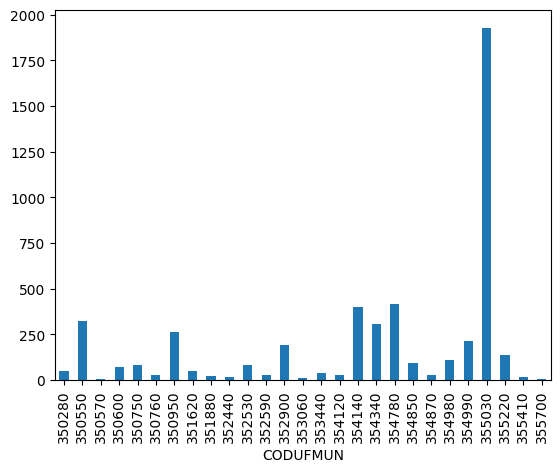

In [31]:

result = cancer_dataframe_pf[cancer_dataframe_pf['CBO'] == '225122'].groupby('CODUFMUN')['CBO'].count()
print(result)
result.plot(kind='bar')
#Contagem de 225122 Médico cancerologista pediátrico por município.

## Leitura de códigos de município

In [32]:
ibge_file_path = os.path.join(
    r'/content/',
    local_folder_name,
    project_folder_name,
    'ibge_data',
    'ibge_cidades.csv')

codigo_municipios = pd.read_csv(
    ibge_file_path,
    sep=';')
codigo_municipios['CODUFMUN'] = (codigo_municipios.id / 10).astype(int)
codigo_municipios


,id,nome,id_uf,nome_uf,CODUFMUN
0,1100015,Alta Floresta D'Oeste,11,Rondônia,110001
1,1100023,Ariquemes,11,Rondônia,110002
2,1100031,Cabixi,11,Rondônia,110003
3,1100049,Cacoal,11,Rondônia,110004
4,1100056,Cerejeiras,11,Rondônia,110005
...,...,...,...,...,...
5565,5222005,Vianópolis,52,Goiás,522200
5566,5222054,Vicentinópolis,52,Goiás,522205
5567,5222203,Vila Boa,52,Goiás,522220
5568,5222302,Vila Propício,52,Goiás,522230


In [36]:
colunas_cnes = ['COMPETEN','CNES', 'CODUFMUN', 'REGSAUDE', 'MICR_REG', 'CBO' ]
colunas_municipios = ['nome','nome_uf','CODUFMUN']

cancer_dataframe_pf.CODUFMUN = cancer_dataframe_pf.CODUFMUN.astype(int)

dados_com_codigos = pd.merge(
    cancer_dataframe_pf[colunas_cnes],
    codigo_municipios[colunas_municipios],
    on="CODUFMUN")

dados_com_codigos['mes'] = pd.to_datetime(dados_com_codigos.COMPETEN, format='%Y%M').dt.date
dados_com_codigos

,COMPETEN,CNES,CODUFMUN,REGSAUDE,MICR_REG,CBO,nome,nome_uf,mes
0,202101,2048205,350160,0212,,225121,Americana,São Paulo,2021-01-01
1,202101,2058790,350160,0207,,225121,Americana,São Paulo,2021-01-01
2,202101,2082179,350160,0207,,225121,Americana,São Paulo,2021-01-01
3,202101,5284007,350160,0207,,225121,Americana,São Paulo,2021-01-01
4,202101,5284007,350160,0207,,225121,Americana,São Paulo,2021-01-01
...,...,...,...,...,...,...,...,...,...
90165,202210,3503135,350850,,,225121,Caçapava,São Paulo,2022-01-01
90166,202211,3503135,350850,,,225121,Caçapava,São Paulo,2022-01-01
90167,202212,3503135,350850,,,225121,Caçapava,São Paulo,2022-01-01
90168,202212,4047672,353760,,,225121,Peruíbe,São Paulo,2022-01-01


## Conteúdo das colunas com datas

In [38]:
#cancer_dataframe_ar[['AP_CMP','AP_DTINIC', 'AP_DTFIM', 'AP_DTOCOR']]

# Montagem do dataset cancer, consolidando procedimentos

Este dataset consolida registros dois tipos de procedimentos (AQ e AR)

Possui as seguintes colunas:

 - data: valores da coluna **AP_CMP** (AR e AQ);
 - paciente (cns_encrypted): valores da coluna **AP_CNSPCN** (AR e AQ);
 - estadiamento: valores dascolunas **AQ_ESTADI** (AQ) e **AR_ESTADI** (AR);
 - custo: valores da coluna **AP_VL_AP** (AQ ou AR) convertido para double;
 - municipio: valores da coluna **AP_MUNPCN** (AQ ou AR);
 - obito: valores da coluna **AP_OBITO** (AQ ou AR), convertido para inteiro;
 - tipo: tipo de procedimento ('ar' ou 'aq').

## Transformação dos tipos das colunas
 - custo (AP_VL_AP) em double
 - Indicação de óbito (AP_OBITO) em inteiro.

In [ ]:
cancer_dataframe_aq['custo'] = cancer_dataframe_aq['AP_VL_AP'].astype(np.double)
cancer_dataframe_ar['custo'] = cancer_dataframe_ar['AP_VL_AP'].astype(np.double)
cancer_dataframe_aq['obito'] = cancer_dataframe_aq['AP_OBITO'].astype(np.integer)
cancer_dataframe_ar['obito'] = cancer_dataframe_ar['AP_OBITO'].astype(np.integer)

## União entre AQ e AR

In [ ]:
columns_aq = ['AP_CMP', 'AP_CNSPCN', 'AQ_ESTADI', 'custo', 'AP_MUNPCN', 'obito']
columns_ar = ['AP_CMP', 'AP_CNSPCN', 'AR_ESTADI', 'custo', 'AP_MUNPCN', 'obito']

normalized_columns = ['data','paciente','estadiamento', 'custo', 'municipio', 'obito']

renamed_aq = cancer_dataframe_aq[columns_aq]
renamed_aq.columns = normalized_columns
renamed_aq['tipo'] = 'aq'

renamed_ar = cancer_dataframe_ar[columns_ar]
renamed_ar.columns = normalized_columns
renamed_ar['tipo'] = 'ar'

cancer_dataframe = pd.concat(
    [
      renamed_aq,
      renamed_ar
    ],
    ignore_index=True)
cancer_dataframe

## Cria arquivo de registros de procedimentos (radioterapia e quimioterapia)

In [ ]:
cancer_dataframe.to_parquet(
    f'cancer.parquet.gzip',
    compression='gzip')

In [ ]:
cancer_dataframe = pd.read_parquet(
    f'{DESTINATION_FOLDER}cancer.parquet.gzip')

cancer_dataframe.info()

In [ ]:
cancer_dataframe

# Montagem do dataset de Exames de Paciente (1 linha por paciente)

Colunas:

 - Chave da paciente (cns_encrypted)
 - Custo total do tratamento
 - Estadiamento inicial
 - Estadiamento final
 - Indicação de óbito
 - Localização de moradia

## Proposta de solução:

 - Tipos de arquivos a serem utilizados: AQ e AR
 - chave do paciente:
  - AQ: coluna AP_CNSPCN
  - AR: coluna AP_CNSPCN  
 - custo total do tratamento: será uma estimativa considerando apenas radioterapia e quimioterapia, calculado somando os valores dos procedimentos (presentes em AR e AQ), para cada chave de paciente. Sendo:
   - custos em AQ: soma de AP_VL_AP;
   - custos em AR: soma de AP_VL_AP.
 - Estadiamento inicial: calculado utilizando o valor do estadiamento (presentes em AQ:AQ_ESTADI e AR:AR_ESTADI) do registro mais antigo de radioterapia ou quimioterapia, de um determinado paciente;
 - Estadiamento final: calculado utilizando o valor do estadiamento (presentes em AQ:AQ_ESTADI e AR:AR_ESTADI) do registro mais recente de radioterapia ou quimioterapia, de um determinado paciente;
 - Localização de moradia: utilizar coluna AP_MUNPCN (presentes em AR e AQ). Talvez criar dois campos, AP_MUNPCN presente no registro mais antigo e AP_MUNPCN presente no registro mais novo;
 - Indicação de óbito: valor máximo do campo AP_OBITO, presente em AQ e AR (0: sem indicação e 1:com indicação de óbito) O valor 1 indicará óbito.

## Cálculo dos valores considerando apenas AQ e AR

**SE O ARQUIVO DE PACIENTES JA FOI CRIADO, PASSAR PARA [ESTE COMANDO](#scrollTo=N65hubVP_--P)**

In [ ]:
df_paciente = cancer_dataframe\
    .sort_values(by=['data'], ascending=True)\
    .groupby(['paciente'])\
    .agg(
        data_primeiro_estadiamento=('data', 'first'),
        data_ultimo_estadiamento=('data', 'last'),
        primeiro_estadiamento=('estadiamento', 'first'),
        maior_estadiamento=('estadiamento', 'max'),
        ultimo_estadiamento=('estadiamento', 'last'),
        custo_total=('custo', 'sum'),
        primeiro_municipio=('municipio', 'first'),
        ultimo_municipio=('municipio', 'last'),
        indicacao_obito=('obito', 'max'),
        )\
    .reset_index()

df_paciente

## Validação dados cálculos em um dos pacientes

In [ ]:
cancer_dataframe[cancer_dataframe.paciente == df_paciente['paciente'][65794]][['data','paciente','estadiamento','municipio', 'obito']]

## Pacientes com marcação de óbito

In [ ]:
df_paciente[df_paciente.indicacao_obito == 1]

## Pacientes com ultimo estadiamento menor que o maior estadiamento identificado

In [ ]:
df_paciente[df_paciente.maior_estadiamento > df_paciente.ultimo_estadiamento]

## Cria arquivo de pacientes

In [ ]:
df_paciente.to_parquet(
    f'pacientes.parquet.gzip',
    compression='gzip')

## Le arquivo de pacientes, se já existir

In [ ]:
df_paciente = pd.read_parquet(
    f'{DESTINATION_FOLDER}pacientes.parquet.gzip')

In [ ]:
df_paciente

# Montagem do dataset de Procedimentos com dados consolidados Paciente (1 linha por procedimento)

Colunas:

  - data: data do procedimento;
  - paciente: código do paciente;
  - estadiamento: estadiamento anotado no procedimento;
  - custo: custo do procedimento;
  - municipio: municipio do estadiamento;
  - obito: anotação de óbito no procedimento;
  - tipo: tipo de procedimento (ar - radioterapia ou aq - quimioterapia)
  **dados consolidados de todos os procedimentos do paciente**
  - data_primeiro_estadiamento: data do primeiro procedimento do paciente;
  - data_ultimo_estadiamento: data do último procedimento do paciente;
  - primeiro_estadiamento: primeiro estadiamento identificado no paciente;
  - maior_estadiamento: maior estadiamento identificado no paciente;
  - ultimo_estadiamento: ultimo estadiamento identificado no paciente;
  - custo_total: custo total dos procedimentos do paciente;
  - primeiro_municipio: municipio do primeiro procedimento do paciente;
  - ultimo_municipio: municipio do último procedimento do paciente;
  - indicacao_obito: indica se o paciente tem marcação de obito em algum procedimento.

In [ ]:
procedimentos_e_pacientes = pd.merge(
    cancer_dataframe,
    df_paciente,
    on='paciente',
    how="outer")

In [ ]:
procedimentos_e_pacientes

In [ ]:
procedimentos_e_pacientes.info()

In [ ]:
procedimentos_e_pacientes.to_parquet(
    f'procedimentos_e_pacientes.parquet.gzip',
    compression='gzip')

## Le arquivo de procedimentos e pacientes, se já existir

In [ ]:
procedimentos_e_pacientes = pd.read_parquet(
    f'{DESTINATION_FOLDER}procedimentos_e_pacientes.parquet.gzip')

# Criação de dataset de consolidando dados de pacientes por estadiamento/municipio/mês

Colunas:

  - data: mês do procedimento;
  - municipio: municipio do procedimento;
  - primeiro_estadiamento: estadiamento no primeiro procedimento do paciente (teoricamente, informa diagnostico precoce ou tardio);
  - custo_estadiamento: soma dos custos dos procedimentos para um dado mes/municipio/estadiamento;
  - numero_pacientes: número de pacientes no mes/municipio/estadiamento;
  - obtitos: número de obitos no mes/municipio/estadiamento;
  - obito_futuro: pacientes com anotação de obito no futuro;
  - numero_procedimentos: número de procedimentos realizados no mes/municipio/estadiamento;  

In [ ]:
dados_estad_municipio_mensal = procedimentos_e_pacientes\
    .sort_values(by=['data'], ascending=True)\
    .groupby(['data', 'municipio','primeiro_estadiamento'])\
    .agg(
        custo_estadiamento=('custo', 'sum'),
        numero_pacientes=('paciente', 'nunique'),
        obtitos=('obito', 'sum'),
        obito_futuro=('indicacao_obito', 'sum'),
        numero_procedimentos=('data','count')
        )\
    .reset_index()
dados_estad_municipio_mensal

In [ ]:
dados_estad_municipio_mensal.to_parquet(
    f'dados_estad_municipio_mensal.parquet.gzip',
    compression='gzip')

## Le arquivo, se já existir

In [ ]:
dados_estad_municipio_mensal = pd.read_parquet(
    f'{DESTINATION_FOLDER}dados_estad_municipio_mensal.parquet.gzip')

# Criação de dataset de consolidando dados de pacientes por estadiamento/mês

Colunas:

  - data: mês do procedimento;
  - primeiro_estadiamento: estadiamento no primeiro procedimento do paciente (teoricamente, informa diagnostico precoce ou tardio);
  - numero_municipios: municipios com procedimentos mes/estadiamento;  
  - custo_estadiamento: soma dos custos dos procedimentos para um dado mes/estadiamento;
  - numero_pacientes: número de pacientes no mes/estadiamento;
  - obtitos: número de obitos no mes/estadiamento;
  - obito_futuro: pacientes com anotação de obito no futuro;
  - numero_procedimentos: número de procedimentos realizados no mes/estadiamento.  

In [ ]:
dados_estad_mensal = dados_estad_municipio_mensal\
    .sort_values(by=['data'], ascending=True)\
    .groupby(['data', 'primeiro_estadiamento'])\
    .agg(
        custo_estadiamento=('custo_estadiamento', 'sum'),
        numero_pacientes=('numero_pacientes', 'sum'),
        numero_municipios=('municipio', 'nunique'),
        obtitos=('obtitos', 'sum'),
        obito_futuro=('obito_futuro', 'sum'),
        numero_procedimentos=('numero_procedimentos','sum')
        )\
    .reset_index()
dados_estad_mensal

In [ ]:
dados_estad_mensal.to_parquet(
    f'dados_estad_mensal.parquet.gzip',
    compression='gzip')